# **TikTok**
# Clasificación de la categoría de video empleando ML


Vamos a crear un modelo de machine learning para ayudarnos a tomar la decisión de si un video es una crítica o una opinión basándonos en los datos. En caso de poder predecir de manera correcta, TikTok puede reducir el retraso en los informes de los usuarios y priorizarlos de manera más eficiente.

El objetivo es de este modelo es predecir si un vídeo de TikTok presenta una «afirmación» o una «opinión».

# ETL

Realizar la selección, extracción y transformación de características para preparar los datos para el modelado.



**Necesidad empresarial y objetivo del modelo**

Los usuarios de TikTok pueden denunciar los vídeos que consideren que infringen los términos de servicio de la plataforma. Dado que cada día se crean y se ven millones de vídeos en TikTok, esto significa que se denuncian muchos vídeos, demasiados para que un moderador humano los revise individualmente.

Los análisis indican que, cuando los autores infringen los términos de servicio, es mucho más probable que estén presentando una reclamación que una opinión. Por lo tanto, resulta útil poder determinar qué vídeos contienen reclamaciones y cuáles son opiniones.

TikTok quiere crear un modelo de aprendizaje automático que ayude a identificar las reclamaciones y las opiniones. Los vídeos etiquetados como opiniones serán menos propensos a ser revisados por un moderador humano. Los vídeos etiquetados como afirmaciones se clasificarán posteriormente mediante un proceso posterior para determinar si deben recibir prioridad para su revisión. Por ejemplo, tal vez los vídeos clasificados como afirmaciones se clasificarían según el número de veces que se han denunciado, y luego el x % superior sería revisado por un humano cada día.

Un modelo de aprendizaje automático sería de gran ayuda para presentar a los moderadores humanos los vídeos que más probablemente infrinjan los términos de servicio de TikTok.

La variable binaria 'claim_status' es la que nos interesa predecir. Debemos predecir para cada vídeo si su estado es una reclamación o una opinión.

La métrica que escojamos para evaluar la calidad del modelo va a a depender de como son los casos de error del modelo, es decir en función de los falsos positivos y falsos negativos.

* Falso positivo: Cuando el modelo predice un video como reclamación y es una opinión.
* Falso negativo: Cuando el modelo predice que un video es una opinión y es una reclamación.

# ¿En este caso que tipo de error nos interesa minimizar lo máximo posible?

En este contexto es peor cometer un error de falso negativo que de falso positivo. Es prioritario seleccionar los vídeos que no cumplen los términos de servicio aunque esto suponga que algunos videos de opinión sean clasificados como reclamaciones y pasen por un proceso de verificación.

# **¿Cómo procedería?**

**Modelado del flujo de trabajo y proceso de selección del modelo**

En este conjunto de datos hay aproximadamente 20 000 vídeos en la muestra. Esto es suficiente para llevar a cabo un riguroso flujo de trabajo de validación del modelo, dividido en los siguientes pasos:

1. Dividir los datos en conjuntos de entrenamiento/validación/prueba (60/20/20).
2. Ajustar los modelos y optimizar los hiperparámetros en el conjunto de entrenamiento.
3. Realizar la selección final del modelo en el conjunto de validación.
4. Evaluar el rendimiento del modelo ganador en el conjunto de prueba.

**Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim



**2. What are the ethical implications of building the model?**
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.


### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importar paquetes para el procesamiento y modelado de datos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

## **Examinar el dataset, extraer información de resumen y estadísticas descriptivas.**

In [3]:
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Número de filas y columnas e información básica sobre las variables y si poseen datos nulos.

In [4]:
data.shape

(19382, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


### Estadísticas descriptivas del dataset.

In [6]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


### Búsqueda de datos faltantes. 

In [ ]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

### Al tratarse de pocos casos, se procede a eliminar las filas donde hay NA.

In [7]:
data = data.dropna(axis=0)

### Búsqueda de datos duplicados.

In [8]:
data.duplicated().sum()

np.int64(0)

### No se encontraton datos duplicados en el conjunto de datos.

# Búsqueda de datos atípicos 'outliers'.

El modelo de 'random forest' es robusto con los datos atípicos y no hay necesidad de eliminar estos casos.

In [ ]:
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Aproximadamente el 50.3% del dataset representa reclamaciones y el 49.7% representa opiniones, así que el dataset está balanceado.

# Transformación

## Ingeniería de características.

**Nueva variable:** Número de caracteres. 

In [9]:
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calcular la longitud media de reclamaciones y opiniones.



In [10]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


# Visualizaciones.

Histograma para ver la distribución de la longitud de cada mensaje.

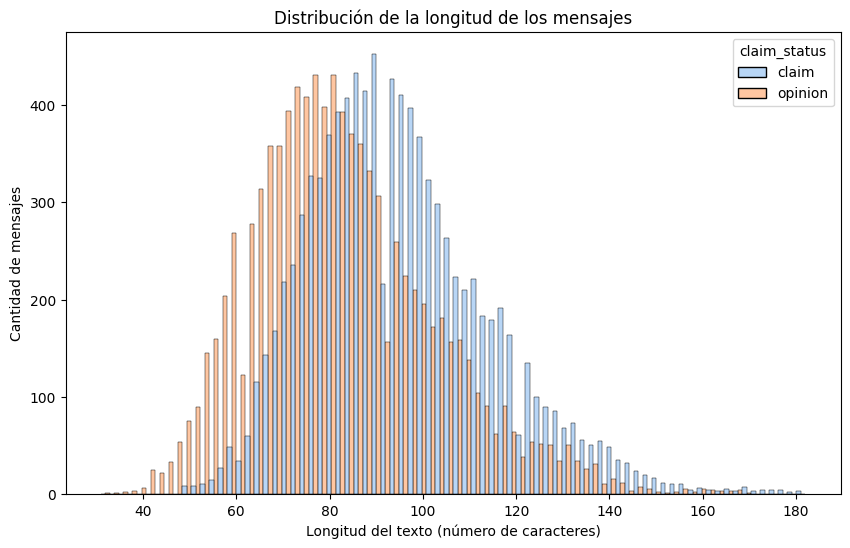

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("Longitud del texto (número de caracteres)")
plt.ylabel("Cantidad de mensajes")
plt.title("Distribución de la longitud de los mensajes")
plt.show()

La distribución del número de caracteres para ambos grupos es aproximadamente normal. Se aprecia que los vídeos que son reclamaciones presentan una cantidad media de caracteres mayor que los que son de opinión.

**Selección y transformación de características**

Codificación de variables categóricas.

In [18]:
X = data.copy()
X = X.drop(['#', 'video_id'], axis=1)
# Codificación de la variable objetivo
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Codidificación de variables dummy
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

C:\Users\alvar\AppData\Local\Temp\ipykernel_31704\2670186918.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### Separar los datos en variables parapredictoras y variable objetivo

**Variable objetivo**

En este caso es ["claim_status"]
* 0 representa opinión
* 1 representa reclamación

In [19]:
y = X['claim_status']

**Variables predictoras**

In [20]:
X = X.drop(['claim_status'], axis=1)
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### Crear los conjuntos de datos train/validate/test

Separando los datos en sets de entrenamiento y test, 80/20.

In [21]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Separar los datos de entrenamiento en entrenamiento y validación, 75/25, para que el ratio final sea 60/20/20 para train, val, test.

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [19]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

### **Tokenizar la columna de texto**

Ideas básicas sobre el procesamiento del lenguaje natural (NLP), debido a la naturaleza de los datos proporcionados en este proyecto de TikTok.

La característica `video_transcription_text` está basada en texto. No es una variable categórica, ya que no tiene un número fijo de valores posibles. Una forma de extraer características numéricas de ella es mediante un algoritmo de bolsa de palabras como [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

`CountVectorizer` funciona dividiendo el texto en n-gramas, que son grupos de n palabras consecutivas. 

Este proceso se repetiría para cada observación del conjunto de datos, y cada n-gram se trataría como una característica distinta. A continuación, el texto de cada observación se compara con la matriz completa de n-gramas y se contabiliza el número de ocurrencias:  Esto se haría con el texto de cada observación de los datos, y el texto de cada observación se analizaría para obtener el recuento de todas las frases de dos palabras de todo el conjunto de datos para cada observación, creando una gran matriz.

Si el texto se divide en 1-gramas, cada característica de la matriz es una palabra individual.

Una vez creada la matriz de recuento, `CountVectorizer` le permite elegir conservar solo los n-gramas que aparecen con más frecuencia. Usted especifica cuántos. Los n-gramas que seleccione se pueden utilizar como características en un modelo.

Dividir el texto en n-gramas es un ejemplo de tokenización. La tokenización es el proceso de dividir el texto en unidades más pequeñas para derivar el significado de los tokens resultantes.

Este cuaderno divide el texto de la transcripción de cada vídeo en 2-gramas y 3-gramas, y luego toma los 15 tokens que aparecen con más frecuencia en todo el conjunto de datos para utilizarlos como características.

In [23]:
# Crear un objeto `CountVectorizer`, que convierte una colección de texto en una matriz de recuento de tokens y coja los 15 n-gramas más frecuentes.
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,'english'
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(2, ...)"
,analyzer,'word'


Ajuste el vectorizador a los datos de entrenamiento (genere los n-gramas) y transforme (cuente las ocurrencias).

In [24]:
# Extraer las características de la columna de texto en los datos de entrenamiento
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11450, 15))

In [26]:
# Ubicar los datos de recuento en un dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# Concatenar las nuevas características de recuento con el resto de las características en X_train
# Resetear los índices después de eliminar video_transcription_text para que se alineen con los de `X_train` y `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Obtenga recuentos de n-gramas para los datos de validación. Tenga en cuenta que el vectorizador no se está reajustando a los datos de validación. Solo los está transformando. En otras palabras, las transcripciones de los vídeos en los datos de validación solo se comparan con los n-gramas encontrados en los datos de entrenamiento.

In [28]:
# Extraer las características de la columna de texto en los datos de validación
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(3817, 15))

In [29]:
# Extraer las características de la columna de texto en los datos de validación
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [30]:
# Concatenar las nuevas características de recuento con el resto de las características en X_val_final
# Resetear los índices después de eliminar video_transcription_text para que se alineen con los de `X_val` y `count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


Hacemos lo mismo con los datos de test

In [31]:
# Extraer las características de la columna de texto en los datos de test
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Colocar la representación numérica de `video_transcription_text` del conjunto de test en un dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenar `X_test` y `test_count_df` para formar el dataframe final para los datos de test (`X_test_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


# **Build models**

### **Random forest**


Ajuste un modelo de random forest con el dataset de entrenamiento. Se empleará Cross-validation pata ajustar los hyperparámetros y seleccionart el modelo que obtiene mejor recall (exactitud).

In [32]:
rf = RandomForestClassifier(random_state=0)

# Diccionario de hiperparámetros para ajustar con GridSearchCV
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Métricas a evaluar durante la validación cruzada
scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [33]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: total: 8min 11s
Wall time: 8min 31s


,estimator,RandomForestC...andom_state=0)
,param_grid,"{'max_depth': [5, 7, ...], 'max_features': [0.3, 0.6], 'max_samples': [0.7], 'min_samples_leaf': [1, 2], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


| Parámetro                    | Descripción                                                                                                                                                  | Valor actual                                       |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------- |
| **n_estimators**             | Número de árboles en el bosque. Cuantos más haya, mejor suele ser el rendimiento, aunque aumenta el tiempo de cómputo.                                       | **200**                                            |
| **criterion**                | Criterio usado para medir la calidad de una división. `'gini'` mide la impureza Gini (alternativa: `'entropy'`).                                             | **'gini'**                                         |
| **max_depth**                | Profundidad máxima de los árboles. Si es `None`, los nodos se expanden hasta que todas las hojas sean puras o tengan menos muestras que `min_samples_split`. | **None**                                           |
| **min_samples_split**        | Número mínimo de muestras necesarias para dividir un nodo. Evita sobreajuste si se incrementa.                                                               | **2**                                              |
| **min_samples_leaf**         | Número mínimo de muestras requeridas en una hoja. También ayuda a evitar sobreajuste.                                                                        | **1**                                              |
| **min_weight_fraction_leaf** | Fracción mínima del peso total (en muestras ponderadas) que debe tener una hoja.                                                                             | **0.0**                                            |
| **max_features**             | Porcentaje de características consideradas al dividir un nodo. Controla la aleatoriedad del bosque.                                                          | **0.6** (usa el 60% de las variables por división) |
| **max_leaf_nodes**           | Número máximo de hojas permitidas. Si es `None`, no se limita.                                                                                               | **None**                                           |
| **min_impurity_decrease**    | Umbral de impureza mínima para hacer una división. Solo divide si mejora la pureza más que este valor.                                                       | **0.0**                                            |
| **bootstrap**                | Si es `True`, los árboles se entrenan con muestras con reemplazo (método bootstrap).                                                                         | **True**                                           |
| **oob_score**                | Si se usa validación *out-of-bag* (fuera de la bolsa) para estimar el rendimiento.                                                                           | **False**                                          |
| **n_jobs**                   | Número de núcleos de CPU usados. `None` usa solo uno; `-1` usaría todos.                                                                                     | **None**                                           |
| **random_state**             | Semilla para reproducibilidad de los resultados.                                                                                                             | **0**                                              |
| **verbose**                  | Nivel de detalle mostrado durante el entrenamiento.                                                                                                          | **0** (silencioso)                                 |
| **warm_start**               | Si se mantiene el modelo anterior al añadir más árboles.                                                                                                     | **False**                                          |
| **class_weight**             | Peso asignado a cada clase (útil en clases desbalanceadas).                                                                                                  | **None**                                           |
| **ccp_alpha**                | Parámetro de poda (*cost-complexity pruning*). A mayor valor, más fuerte la poda.                                                                            | **0.0**                                            |
| **max_samples**              | Proporción de muestras utilizadas para entrenar cada árbol (si `bootstrap=True`).                                                                            | **0.7** (usa el 70% de las muestras por árbol)     |
| **monotonic_cst**            | Restricciones de monotonía (no aplicadas por defecto).                                                                                                       | **None**                                           |


In [60]:
import pickle 
import os

# Definimos la ruta donde queremos guardar el modelo
path = r'C:\Users\alvar\Desktop\EDA\Tiktok\Github_tiktok'
modelo = "rf1"

In [61]:
def write_pickle(path, model_object, save_name: str):
    file_path = os.path.join(path, save_name + '.pickle')
    with open(file_path, 'wb') as to_write:
        pickle.dump(model_object, to_write)
    print(f"✅ Archivo guardado en: {file_path}")

In [62]:
path = r'C:\Users\alvar\Desktop\EDA\Tiktok\Github_tiktok'
write_pickle(path, modelo, "RandomForest")

✅ Archivo guardado en: C:\Users\alvar\Desktop\EDA\Tiktok\Github_tiktok\RandomForest.pickle


In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

Leer el modelo en vez de entrenarlo de nuevo

In [ ]:
# read_pickle(path, "RandomForest")

Métrica con mejor puntuación

In [34]:
rf_cv.best_score_

np.float64(0.9948228253467271)

Mejores parámetros.

In [35]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Utilizamos el atributo `cv_results_` del objeto `GridSearchCV` ajustado, que devuelve una matriz numpy que se puede convertir en un marco de datos pandas. A continuación, examinar la columna `mean_test_precision` de este marco de datos en el índice que contiene los resultados del mejor modelo. 

In [38]:
rf_results_df = pd.DataFrame(rf_cv.cv_results_)
rf_results_df['mean_test_precision'][rf_cv.best_index_]

np.float64(0.9994806638131711)

El modelo trabaja excepcionalmente bien, con un valor medio de recall de 0.9995 entre los 5 conjuntos de validación. Al comprobar que la precisión fué tan elevada, deja claro que el modelo lleva a cabo una clasificación prácticamente perfecta.

Precisión = TP /(TP + FP)

Mide la proporción de verdaderos positivos entre el total de casos que fueron clasificados como positivos.

### **Modelo XGBoost**

In [39]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

#Diccionario de hiperparámetros
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Lista de métricas a evaluar durante la validación cruzada
scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [40]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 13min 46s
Wall time: 1min 2s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, ...], 'min_child_weight': [3, 5], 'n_estimators': [300, 500]}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


| Parámetro                                 | Descripción                                                                                                                            | Valor actual                                    |
| ----------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------- |
| **objective**                             | Define la función objetivo o tipo de problema. `'binary:logistic'` indica clasificación binaria con salida en probabilidad (sigmoide). | **'binary:logistic'**                           |
| **base_score**                            | Valor inicial de probabilidad previa (si no se especifica, se estima automáticamente).                                                 | **None**                                        |
| **booster**                               | Tipo de modelo base: `'gbtree'` (por defecto, árboles), `'gblinear'` (lineal), `'dart'` (dropout trees).                               | **None** (usa `'gbtree'` por defecto)           |
| **callbacks**                             | Funciones personalizadas que se ejecutan durante el entrenamiento.                                                                     | **None**                                        |
| **colsample_bylevel**                     | Fracción de características usadas en cada nivel del árbol. Controla la aleatoriedad.                                                  | **None** (usa 1.0 por defecto, es decir, todas) |
| **colsample_bynode**                      | Fracción de variables usadas al dividir un nodo.                                                                                       | **None**                                        |
| **colsample_bytree**                      | Fracción de variables usadas al construir cada árbol. Reduce sobreajuste si < 1.                                                       | **None** (equivale a 1.0)                       |
| **device**                                | Permite especificar el dispositivo (`'cpu'` o `'cuda'` para GPU).                                                                      | **None**                                        |
| **early_stopping_rounds**                 | Número de iteraciones sin mejora tras las cuales se detiene el entrenamiento.                                                          | **None** (no se usa parada temprana)            |
| **enable_categorical**                    | Permite usar variables categóricas nativas de XGBoost (True en versiones nuevas).                                                      | **False**                                       |
| **eval_metric**                           | Métrica de evaluación (e.g. `'logloss'`, `'auc'`). Si es None, se elige automáticamente según `objective`.                             | **None**                                        |
| **feature_types**                         | Tipos de variables (numéricas/categóricas).                                                                                            | **None**                                        |
| **feature_weights**                       | Pesos de cada característica.                                                                                                          | **None**                                        |
| **gamma**                                 | Reducción mínima de pérdida necesaria para dividir un nodo. Controla complejidad (regularización).                                     | **None** (equivale a 0)                         |
| **grow_policy**                           | Estrategia de crecimiento del árbol (`'depthwise'` o `'lossguide'`).                                                                   | **None** (usa `'depthwise'` por defecto)        |
| **importance_type**                       | Método de cálculo de importancia de características (`'gain'`, `'weight'`, `'cover'`, `'total_gain'`).                                 | **None**                                        |
| **interaction_constraints**               | Restringe combinaciones de variables que pueden interactuar.                                                                           | **None**                                        |
| **learning_rate (eta)**                   | Tasa de aprendizaje. Cuanto menor, más lento pero estable el aprendizaje.                                                              | **0.1**                                         |
| **max_bin**                               | Número máximo de bins para variables continuas (para histogramas).                                                                     | **None**                                        |
| **max_cat_threshold / max_cat_to_onehot** | Controlan cómo se manejan categorías con muchas clases.                                                                                | **None**                                        |
| **max_delta_step**                        | Límite del paso máximo de actualización del peso. Suele usarse en problemas desbalanceados.                                            | **None**                                        |
| **max_depth**                             | Profundidad máxima de los árboles. Valores bajos reducen sobreajuste.                                                                  | **4**                                           |
| **max_leaves**                            | Número máximo de hojas.                                                                                                                | **None**                                        |
| **min_child_weight**                      | Peso mínimo de las instancias en un nodo hijo. Aumentarlo hace el modelo más conservador.                                              | **5**                                           |
| **missing**                               | Valor que se considera como “faltante” (NaN).                                                                                          | **NaN**                                         |
| **monotone_constraints**                  | Restringe la dirección de influencia de una variable (monótona).                                                                       | **None**                                        |
| **multi_strategy**                        | Estrategia para problemas multiclase.                                                                                                  | **None**                                        |
| **n_estimators**                          | Número de árboles (boosting rounds).                                                                                                   | **300**                                         |
| **n_jobs**                                | Núcleos de CPU usados. `None` usa 1; `-1` usaría todos.                                                                                | **None**                                        |
| **num_parallel_tree**                     | Número de árboles en paralelo (para modelos como Random Forest).                                                                       | **None**                                        |
| **random_state**                          | Semilla para reproducibilidad.                                                                                                         | **0**                                           |
| **reg_alpha**                             | Regularización L1 (castiga pesos grandes).                                                                                             | **None** (equivale a 0)                         |
| **reg_lambda**                            | Regularización L2 (similar a Ridge).                                                                                                   | **None** (equivale a 1)                         |
| **sampling_method**                       | Método de muestreo: `'uniform'` o `'gradient_based'`.                                                                                  | **None**                                        |
| **scale_pos_weight**                      | Peso relativo de las clases positivas (para desbalance).                                                                               | **None**                                        |
| **subsample**                             | Fracción de muestras usadas por árbol (como bootstrap).                                                                                | **None** (equivale a 1.0)                       |
| **tree_method**                           | Algoritmo de construcción de árboles (`'auto'`, `'hist'`, `'gpu_hist'`, etc.).                                                         | **None** (elige `'auto'`)                       |
| **validate_parameters**                   | Si se validan los parámetros antes del entrenamiento.                                                                                  | **None**                                        |
| **verbosity**                             | Nivel de mensajes en consola (0 = silencioso).                                                                                         | **None**                                        |


In [63]:
modelo = "xgb1"
write_pickle(path, modelo, "XGBoost")

✅ Archivo guardado en: C:\Users\alvar\Desktop\EDA\Tiktok\Github_tiktok\XGBoost.pickle


In [35]:
xgb_cv.best_score_

0.9898176171763818

In [36]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

Acceder a los resultados de GridSearch y convertirlos en un dataframe de pandas y Examinar los resultados de GridSearch en la columna `mean_test_precision` en el mejor índice


In [ ]:
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)
xgb_results_df['mean_test_precision'][xgb_cv.best_index_]

0.9989540885869099

Este modelo también funciona excepcionalmente, sin embargo la precisión es ligeramente inferior a la obtenida mediante Random Forest.

# Evaluación de los modelos con los datos de validación.

#### **Random forest**

In [42]:
# Usar el mejor modelo de Random Forest para hacer predicciones en el conjunto de validación
y_pred = rf_cv.best_estimator_.predict(X_val_final)

In [43]:
y_pred

array([1, 0, 1, ..., 1, 1, 1], shape=(3817,))

In [44]:
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

## Matriz de confusión  para visualizar los resultados del modelo de clasificación. 

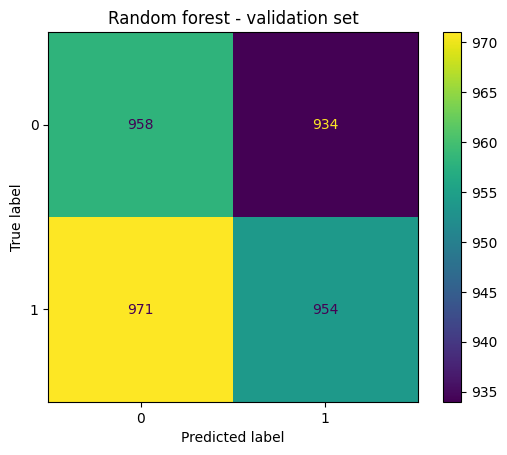

In [54]:
# Calcula la matriz de confusión comparando los valores reales (y_val) con las predicciones del modelo (y_pred)
log_cm = confusion_matrix(y_val, y_pred)

# Crea  el objeto para visualizar la matriz de confusión.
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Genera el gráfico de la matriz de confusión
log_disp.plot()
plt.title('Random forest - validation set');
plt.show()


El cuadrante superior izquierdo muestra el número de negativos verdaderos: el número de opiniones que el modelo clasificó correctamente como tales.

El cuadrante superior derecho muestra el número de falsos positivos: el número de opiniones que el modelo clasificó erróneamente como reclamaciones.

El cuadrante inferior izquierdo muestra el número de falsos negativos: el número de reclamaciones que el modelo clasificó erróneamente como opiniones.

El cuadrante inferior derecho muestra el número de verdaderos positivos: el número de reclamaciones que el modelo clasificó correctamente como tales.

Un modelo perfecto produciría todos los verdaderos negativos y verdaderos positivos, y ningún falso negativo o falso positivo.

Como muestra la matriz de confusión anterior, este modelo produce cinco falsos negativos y cinco falsos positivos.

In [46]:
# Genera un informe de clasificación que incluye precisión, recall, f1-score y soporte para cada clase
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Exemplar response:**

The classification report above shows that the random forest model scores were perfect, but we know they weren't quite perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [47]:
# Emplear el mejor modelo de XGBoost para hacer predicciones en el conjunto de validación
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [48]:
y_pred

array([1, 0, 1, ..., 1, 1, 1], shape=(3817,))

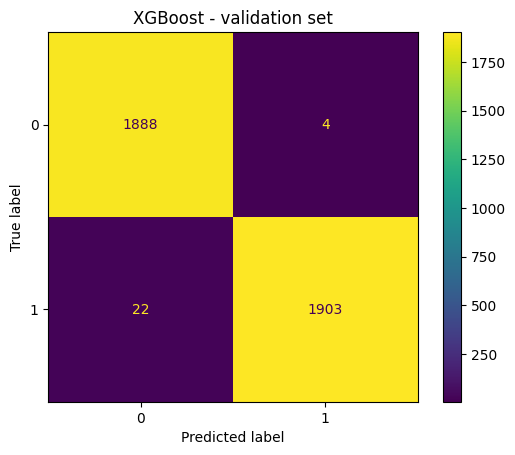

In [49]:
# Calcula la matriz de confusión comparando los valores reales (y_val) con las predicciones del modelo (y_pred)
log_cm = confusion_matrix(y_val, y_pred)

# Crea  el objeto para visualizar la matriz de confusión.
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Genera el gráfico de la matriz de confusión
log_disp.plot()
plt.title('XGBoost - validation set');
plt.show()


In [50]:
# Genera un informe de clasificación que incluye precisión, recall, f1-score y soporte para cada clase
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



Los resultados del modelo XGBoost también fueron casi perfectos. Sin embargo, sus errores tendían a ser falsos negativos. La prioridad era identificar las reclamaciones, por lo que es importante que el modelo sea capaz de capturar todos los vídeos de reclamaciones reales. El modelo de bosque aleatorio tiene mejores puntuaciones y, por lo tanto, es el modelo ganador.

Tanto la arquitectura del modelo Random Forest como la del modelo XGBoost dieron como resultado modelos casi perfectos. No obstante, en este caso, Random Forest funcionó un poco mejor, por lo que es el modelo ganador.

Ahora, utilice el modelo ganador para realizar predicciones sobre los datos de prueba.

In [51]:
# Predicciones sobre el conjunto de test usando el modelo ganador (Random Forest)
y_pred = rf_cv.best_estimator_.predict(X_test_final)

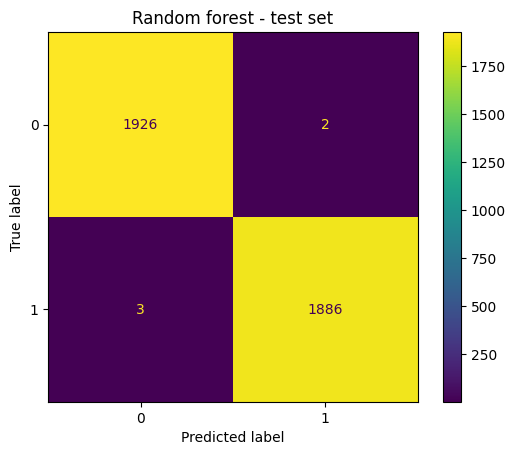

In [52]:
# Calcula la matriz de confusión comparando los valores reales (y_test) con las predicciones del modelo (y_pred)
log_cm = confusion_matrix(y_test, y_pred)

# Crea  el objeto para visualizar la matriz de confusión.
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Genera el gráfico de la matriz de confusión
log_disp.plot()
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**



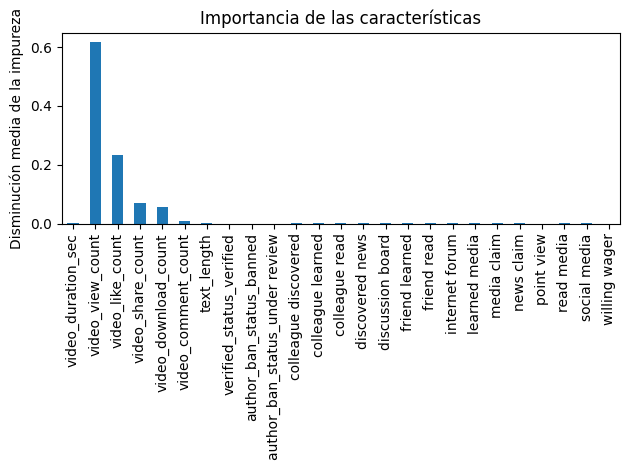

In [56]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Importancia de las características')
ax.set_ylabel('Disminución media de la impureza')
fig.tight_layout()

Las variables mas predictivas están relacionadas con el nivel de interacción generados con el video. 

# **Conclusiones:**


1. *¿Recomendarías utilizar este modelo? ¿Por qué sí o por qué no?*
Sí, se puede recomendar este modelo porque funcionó bien tanto en los datos de validación como en los de prueba. Además, tanto la precisión como las puntuaciones F1 fueron consistentemente altas. El modelo clasificó con mucho éxito las afirmaciones y opiniones.

2. *¿Qué hacía su modelo? ¿Puede explicar cómo realizaba las predicciones?*
Las características más predictivas del modelo estaban relacionadas con los niveles de interacción de los usuarios asociados a cada vídeo. Clasificaba los vídeos en función del número de visualizaciones, «me gusta», comparticiones y descargas que recibían.

3. *¿Hay alguna característica nueva que pueda diseñar y que pueda mejorar el rendimiento del modelo?*
Dado que el modelo funciona actualmente de forma casi perfecta, no es necesario diseñar ninguna característica nueva.

4. *¿Qué características le gustaría tener que pudieran mejorar el rendimiento de su modelo?*
La versión actual del modelo no necesita ninguna característica nueva. Sin embargo, sería útil disponer del número de veces que se ha denunciado el vídeo. También sería útil disponer del número total de denuncias de los usuarios para todos los vídeos publicados por cada autor.